Names, Matriculation Numbers:  
Jie Cheng: 5527191  
Markus Flicke: 5489277  
Bin Wei: 4277156

# Baseline: Just use all features quickly

In [1]:
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import numpy as np
pd.set_option('display.max_columns', 50)

plt.rcParams['figure.figsize'] = (20, 8)   
plt.rcParams['figure.dpi'] = 72             
plt.rcParams['font.size'] = 16               
plt.rcParams['text.usetex'] = False 

In [8]:
FILE_NAME = 'train_imputed.csv'
df_train = pd.read_csv(FILE_NAME)
df_train = df_train.sample(frac=1)
ids = df_train.id
df_train = df_train.drop('id', axis = 1)
N = 14000
def train_test_split(N = 14000, df_train=df_train):
#     df_train = df_train.sample(frac=1)
    x_train = df_train.drop('target', axis = 1).iloc[:N]
    y_train = df_train.target.iloc[:N]

    x_test = df_train.drop('target', axis = 1).iloc[N:]
    y_test = df_train.target.iloc[N:]
    return x_train, y_train, x_test, y_test
x_train, y_train, x_test, y_test = train_test_split(N)

### [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html) is great 77%

In [24]:
def eval_xgboost(rounds = 10, verbose = True, n_jobs = 8):
    dtrain = xgb.DMatrix(x_train.values, label=y_train.values)
    dtest = xgb.DMatrix(x_test.values, label=y_test.values)

    param = {'max_depth': 1, 
             'eta': 0.27, 
             'objective': 'binary:logistic',
             'nthread': n_jobs,
             'eval_metric': 'auc',
             'gamma':1, 
             'lambda': 1,
            }


    evallist = [(dtrain, 'train')] # (dtest, 'eval'), 
    num_round = rounds
    bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=False)
    preds = bst.predict(dtest)

    if verbose:
        print(f'roc_auc: {roc_auc_score(y_test, preds)}')
        print(f'MSE: {mean_squared_error(y_test, preds)}')
        
    return roc_auc_score(y_test, preds), mean_squared_error(y_test, preds)
eval_xgboost(400, verbose = False)

(0.774287089326291, 0.12823995118165607)

In [10]:
%%time
auc_scores = []
mse_scores = []
x = list(range(1,20)) + list(range(20, 101, 10))
for i in x:
    auc_sum = 0
    mse_sum = 0
    for j in range(5):
        x_train, y_train, x_test, y_test = train_test_split()
        auc, mse = eval_xgboost(i, verbose = False)
        auc_sum += auc
        mse_sum += mse
    auc_scores.append(auc_sum/5)
    mse_scores.append(mse_sum/5)

Wall time: 52.1 s


max auc at 60 rounds


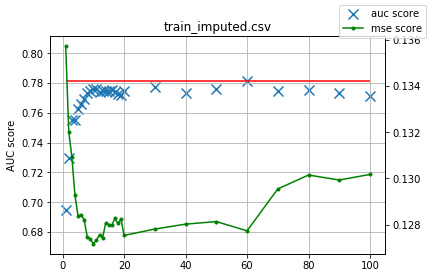

In [11]:
fig, ax1 = plt.subplots(1,1)
ax2 = ax1.twinx()
ax1.scatter(x, auc_scores, marker = 'x', label='auc score', s = 100)
ax2.plot(x, mse_scores, marker = '.', label='mse score', color = 'green')
fig.legend()
plt.xlabel('Rounds of XGboost')
ax1.set_ylabel('AUC score')
plt.title(FILE_NAME)
ax1.grid()
ax1.hlines(max(auc_scores), 1, 100, color = 'red')
print(f'max auc at {x[np.argmax(auc_scores)]} rounds')
plt.savefig(FILE_NAME+'_plot.png')

### Random Forest is consistent 66%

In [12]:
model = RandomForestClassifier(1000, criterion='entropy', n_jobs = 8)

In [13]:
%%time
model.fit(x_train, y_train)
preds = model.predict(x_test)
print(f'roc_auc: {roc_auc_score(y_test, preds)}')
print(f'accuracy: {accuracy_score(y_test, preds)}')

roc_auc: 0.6798801103861689
accuracy: 0.832
Wall time: 19.4 s


### Lightgm is also good at 77%

In [14]:
import lightgbm as lgb
import gc

In [15]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':50, # because training data is sightly unbalanced 
         }

In [16]:
dtrain = lgb.Dataset(x_train, 
                     label=y_train)

dvalid = lgb.Dataset(x_test, 
                     label=y_test)

In [17]:
evals_results = {}
MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result



model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)

del dvalid
gc.collect()

Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.781815	valid's auc: 0.761549
[100]	train's auc: 0.79167	valid's auc: 0.770142
[150]	train's auc: 0.799824	valid's auc: 0.772118
[200]	train's auc: 0.807258	valid's auc: 0.773032
[250]	train's auc: 0.814688	valid's auc: 0.775244
[300]	train's auc: 0.82024	valid's auc: 0.776145
[350]	train's auc: 0.825444	valid's auc: 0.775591
Early stopping, best iteration is:
[304]	train's auc: 0.820686	valid's auc: 0.776626


3879

### Multilayer Perceptron is ok-ish 63%
High variance in outcome

In [19]:
model = MLPClassifier()

In [20]:
%%time
model.fit(x_train, y_train)
preds = model.predict(x_test)
roc_auc_score(y_test, preds)

Wall time: 23.2 s


c:\users\m\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.6339589767957552

### KNN is ok at 55%

0.5417633764034334
Wall time: 2.03 s


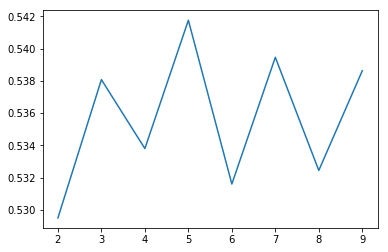

In [18]:
%%time
scores = []
x = range(2,10)
for k in x:
    model = KNeighborsClassifier(k)

    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    scores.append(roc_auc_score(y_test, preds))
plt.plot(x, scores)
print(max(scores))

### Logistic Regression is shit 50%
Few predictions are 1

In [21]:
model = LogisticRegression()

In [22]:
model.fit(x_train, y_train)
preds = model.predict(x_test)
roc_auc_score(y_test, preds)

c:\users\m\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.4987389659520807

### SVC is completely useless 50%
All predictions are 0

In [23]:
%%time
model = SVC()
model.fit(x_train, y_train)
preds = model.predict(x_test)
roc_auc_score(y_test, preds)

c:\users\m\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Wall time: 1min 18s


0.5017849419132384